# Stage 3 - Entity Matching

In [1]:
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

import py_entitymatching as em

IS_DEVELOPING = False

data_dir = './dataset/structured_data/'
A_filename = 'forbes_sample.csv' if IS_DEVELOPING else 'forbes_all_rename.csv'
B_filename = 'nasdaq_sample.csv' if IS_DEVELOPING else 'nasdaq_rename.csv'
blocked_filename = 'blocked_sample.csv' if IS_DEVELOPING else 'blocked.csv'
labeled_filename = 'labeled_sample.csv' if IS_DEVELOPING else 'golden_label.csv'

all_fields = ['Name',"Country", 'Industry', "MarketValue"]

# Set the seed value for reproducibility
seed = 0

## 3 Mathcing

In [2]:
A = pd.read_csv(data_dir + A_filename,  encoding = "ISO-8859-1" )
A = A[['id'] + all_fields]
em.set_key(A, 'id')
B = pd.read_csv(data_dir + B_filename,  encoding = "ISO-8859-1")
B = B[['id'] + all_fields]
em.set_key(B, 'id')
# Load the pre-labeled data
S = em.read_csv_metadata(data_dir + labeled_filename, 
                         key='_id',
                         ltable=A, rtable=B, 
                         fk_ltable='ltable_id', fk_rtable='rtable_id',  encoding = "ISO-8859-1")

Metadata file is not present in the given path; proceeding to read the csv file.


### 3.1 Split training set
Split the labeled data into development set and evaluation set. Use the development set to select the best learning-based matcher.

In [3]:
# Split S into I an J
IJ = em.split_train_test(S, train_proportion=0.6, random_state=seed)
I = IJ['train']
J = IJ['test']
print(Counter(I.is_match))
print(Counter(J.is_match))

Counter({1: 100, 0: 80})
Counter({0: 60, 1: 60})


Save split I, J into files. 

In [4]:
I.to_csv(data_dir +"I.csv")
J.to_csv(data_dir +"J.csv")

### 3.2 Creating features

In [5]:
# Generate a set of features
F = em.get_features_for_matching(A, B)

In [6]:
F.feature_name

0                                 id_id_exm
1                                 id_id_anm
2                            id_id_lev_dist
3                             id_id_lev_sim
4                 Name_Name_jac_qgm_3_qgm_3
5             Name_Name_cos_dlm_dc0_dlm_dc0
6             Name_Name_jac_dlm_dc0_dlm_dc0
7                             Name_Name_mel
8                        Name_Name_lev_dist
9                         Name_Name_lev_sim
10                            Name_Name_nmw
11                             Name_Name_sw
12          Country_Country_jac_qgm_3_qgm_3
13      Country_Country_cos_dlm_dc0_dlm_dc0
14      Country_Country_jac_dlm_dc0_dlm_dc0
15                      Country_Country_mel
16                 Country_Country_lev_dist
17                  Country_Country_lev_sim
18                      Country_Country_nmw
19                       Country_Country_sw
20        Industry_Industry_jac_qgm_3_qgm_3
21    Industry_Industry_cos_dlm_dc0_dlm_dc0
22    Industry_Industry_jac_dlm_

### 3.3 Extracting feature vectors

In [7]:
# Convert the I into a set of feature vectors using F
H = em.extract_feature_vecs(I, 
                            feature_table=F, 
                            attrs_after='is_match',
                            show_progress=False)  
# Display first few rows
H.head()

,_id,ltable_id,rtable_id,id_id_exm,id_id_anm,id_id_lev_dist,id_id_lev_sim,Name_Name_jac_qgm_3_qgm_3,Name_Name_cos_dlm_dc0_dlm_dc0,Name_Name_jac_dlm_dc0_dlm_dc0,...,Country_Country_sw,Industry_Industry_jac_qgm_3_qgm_3,Industry_Industry_cos_dlm_dc0_dlm_dc0,Industry_Industry_jac_dlm_dc0_dlm_dc0,Industry_Industry_mel,Industry_Industry_lev_dist,Industry_Industry_lev_sim,Industry_Industry_nmw,Industry_Industry_sw,is_match
29,4438,1907,564,0,0.295752,4,0.00,0.130435,0.000000,0.000000,...,13.0,0.000000,0.0,0.000000,0.461988,18.0,0.052632,-15.0,1.0,1
146,23473,1881,2550,0,0.737647,4,0.00,0.163636,0.250000,0.142857,...,13.0,0.015625,0.0,0.000000,0.552717,33.0,0.175000,-10.0,4.0,0
16,2770,870,302,0,0.347126,3,0.00,0.357143,0.707107,0.500000,...,13.0,0.264706,0.5,0.333333,0.833601,10.0,0.545455,7.0,11.0,1
56,11077,1298,1014,0,0.781202,3,0.25,0.266667,0.353553,0.200000,...,13.0,0.018519,0.0,0.000000,0.608140,28.0,0.200000,-10.0,4.0,0
75,13987,1366,1467,0,0.931152,2,0.50,0.571429,0.816497,0.666667,...,13.0,0.078431,0.0,0.000000,0.589068,22.0,0.290323,-2.0,7.0,1


In [8]:
# Check if the feature vectors contain missing values
# A return value of True means that there are missing values
any(pd.notnull(H))

True

We observe that the extracted feature vectors contain missing values. We have to impute the missing values for the learning-based matchers to fit the model correctly.

In [9]:
# Impute feature vectors with the mean of the column values.
H = em.impute_table(H, 
                exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
                strategy='mean')

### 3.4 Selecting the best matcher using cross-validation

First, we need to create a set of learning-based matchers. The following matchers are supported in Magellan: (1) decision tree, (2) random forest, (3) naive bayes, (4) svm, (5) logistic regression, and (6) linear regression.

In [10]:
# Create a set of ML-matchers
dt = em.DTMatcher(name='DecisionTree', random_state=seed)
svm = em.SVMMatcher(name='SVM', random_state=seed)
rf = em.RFMatcher(name='RF', random_state=seed)
nb = em.NBMatcher(name='NB')
lg = em.LogRegMatcher(name='LogReg', random_state=seed)
ln = em.LinRegMatcher(name='LinReg')
matchers = [dt, rf, svm, nb, ln, lg]

Now, we select the best matcher using k-fold cross-validation. Here we use 5-fold cross validation and use precision, recall, and F-1 metric to select the best matcher.

In [11]:
# Performing CV using precision
result = em.select_matcher(matchers, table=H, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
        k=5,
        target_attr='is_match', metric='precision', random_state=seed)
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x11322fac8>,5,0.850000,0.9,0.761905,0.761905,0.875000,0.829762
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x11322fb00>,5,0.947368,1.0,0.894737,0.944444,0.857143,0.928739
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x11322fba8>,5,0.772727,0.8,0.642857,0.769231,0.600000,0.716963
3,NB,<py_entitymatching.matcher.nbmatcher.NBMatcher object at 0x11322fa58>,5,0.894737,1.0,0.875000,0.933333,0.900000,0.920614
4,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x11322fc50>,5,0.863636,1.0,0.894737,0.944444,0.823529,0.905269
5,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x11322fbe0>,5,0.909091,1.0,0.809524,0.941176,0.700000,0.871958


In [12]:
# Performing CV using recall
result = em.select_matcher(matchers, table=H, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
        k=5,
        target_attr='is_match', metric='recall', random_state=seed)
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x11322fac8>,5,0.772727,0.818182,0.888889,0.695652,0.933333,0.821757
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x11322fb00>,5,0.818182,0.772727,0.944444,0.739130,0.800000,0.814897
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x11322fba8>,5,0.772727,0.909091,1.000000,0.869565,1.000000,0.910277
3,NB,<py_entitymatching.matcher.nbmatcher.NBMatcher object at 0x11322fa58>,5,0.772727,0.863636,0.777778,0.608696,0.600000,0.724567
4,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x11322fc50>,5,0.863636,0.954545,0.944444,0.739130,0.933333,0.887018
5,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x11322fbe0>,5,0.909091,1.000000,0.944444,0.695652,0.933333,0.896504


In [13]:
# Performing CV using F-1
result = em.select_matcher(matchers, table=H, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
        k=5,
        target_attr='is_match', metric='f1', random_state=seed)
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x11322fac8>,5,0.809524,0.857143,0.820513,0.727273,0.903226,0.823536
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x11322fb00>,5,0.878049,0.871795,0.918919,0.829268,0.827586,0.865123
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x11322fba8>,5,0.772727,0.851064,0.782609,0.816327,0.750000,0.794545
3,NB,<py_entitymatching.matcher.nbmatcher.NBMatcher object at 0x11322fa58>,5,0.829268,0.926829,0.823529,0.736842,0.720000,0.807294
4,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x11322fc50>,5,0.863636,0.976744,0.918919,0.829268,0.875000,0.892714
5,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x11322fbe0>,5,0.909091,1.000000,0.871795,0.800000,0.800000,0.876177


We select random forest matcher for its highest precision.

### 3.5 Debug X (Random Forest)

Split the feature vectors H of the development set I into a training set P and a testing set Q.

In [14]:
# Split H into P and Q
PQ = em.split_train_test(H, train_proportion=0.5, random_state=seed)
P = PQ['train']
Q = PQ['test']

We use the visual debugger for random forest provided by Magellen.

In [15]:
# Debug Random Forest matcher using GUI
em.vis_debug_rf(rf, P, Q, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
        target_attr='is_match')

First we figured out there are some wrong labels. See example below. 

In [19]:
S[77:78]

,Unnamed: 0,_id,ltable_id,rtable_id,ltable_Country,ltable_Industry,ltable_MarketValue,ltable_Name,rtable_Name,rtable_Country,rtable_Sector,rtable_Industry,rtable_MarketValue,is_match
77,14222,14222,2513,1497,United States,Pipelines,3616,Enable Midstream Partners,"EnLink Midstream Partners, LP",United States,Public Utilities,Natural Gas Distribution,6274.755698,1


After fixing the wrong labels manully we reload all the revised data.

In [20]:
# Load the revised labeled data
S = em.read_csv_metadata(data_dir + labeled_filename, 
                         key='_id',
                         ltable=A, rtable=B, 
                         fk_ltable='ltable_id', fk_rtable='rtable_id',  encoding = "ISO-8859-1")

Metadata file is not present in the given path; proceeding to read the csv file.


In [21]:
# Split S into I an J
IJ = em.split_train_test(S, train_proportion=0.6, random_state=seed)
I = IJ['train']
J = IJ['test']
print(Counter(I.is_match))
print(Counter(J.is_match))

Counter({1: 100, 0: 80})
Counter({0: 60, 1: 60})


Save revised split I, J into files. 

In [22]:
I.to_csv(data_dir +"I_revised.csv")
J.to_csv(data_dir +"J_revised.csv")

And recalculate feature vectors.

In [23]:
# Convert the I into a set of feature vectors using F
H = em.extract_feature_vecs(I, 
                            feature_table=F, 
                            attrs_after='is_match',
                            show_progress=False)  
# Display first few rows
H.head()

,_id,ltable_id,rtable_id,id_id_exm,id_id_anm,id_id_lev_dist,id_id_lev_sim,Name_Name_jac_qgm_3_qgm_3,Name_Name_cos_dlm_dc0_dlm_dc0,Name_Name_jac_dlm_dc0_dlm_dc0,...,Country_Country_sw,Industry_Industry_jac_qgm_3_qgm_3,Industry_Industry_cos_dlm_dc0_dlm_dc0,Industry_Industry_jac_dlm_dc0_dlm_dc0,Industry_Industry_mel,Industry_Industry_lev_dist,Industry_Industry_lev_sim,Industry_Industry_nmw,Industry_Industry_sw,is_match
29,4438,1907,564,0,0.295752,4,0.00,0.130435,0.000000,0.000000,...,13.0,0.000000,0.0,0.000000,0.461988,18.0,0.052632,-15.0,1.0,1
146,23473,1881,2550,0,0.737647,4,0.00,0.163636,0.250000,0.142857,...,13.0,0.015625,0.0,0.000000,0.552717,33.0,0.175000,-10.0,4.0,0
16,2770,870,302,0,0.347126,3,0.00,0.357143,0.707107,0.500000,...,13.0,0.264706,0.5,0.333333,0.833601,10.0,0.545455,7.0,11.0,1
56,11077,1298,1014,0,0.781202,3,0.25,0.266667,0.353553,0.200000,...,13.0,0.018519,0.0,0.000000,0.608140,28.0,0.200000,-10.0,4.0,0
75,13987,1366,1467,0,0.931152,2,0.50,0.571429,0.816497,0.666667,...,13.0,0.078431,0.0,0.000000,0.589068,22.0,0.290323,-2.0,7.0,1


In [24]:
# Impute feature vectors with the mean of the column values.
H = em.impute_table(H, 
                exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
                strategy='mean')

### 3.6 Selecting the best matcher using cross-validation - Round 2

In [25]:
# Performing CV using precision
result = em.select_matcher(matchers, table=H, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
        k=5,
        target_attr='is_match', metric='precision', random_state=seed)
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x11322fac8>,5,0.850000,0.9,0.761905,0.761905,0.875000,0.829762
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x11322fb00>,5,0.947368,1.0,0.894737,0.944444,0.857143,0.928739
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x11322fba8>,5,0.772727,0.8,0.642857,0.769231,0.600000,0.716963
3,NB,<py_entitymatching.matcher.nbmatcher.NBMatcher object at 0x11322fa58>,5,0.894737,1.0,0.875000,0.933333,0.900000,0.920614
4,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x11322fc50>,5,0.863636,1.0,0.894737,0.944444,0.823529,0.905269
5,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x11322fbe0>,5,0.909091,1.0,0.809524,0.941176,0.700000,0.871958


In [26]:
# Performing CV using recall
result = em.select_matcher(matchers, table=H, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
        k=5,
        target_attr='is_match', metric='recall', random_state=seed)
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x11322fac8>,5,0.772727,0.818182,0.888889,0.695652,0.933333,0.821757
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x11322fb00>,5,0.818182,0.772727,0.944444,0.739130,0.800000,0.814897
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x11322fba8>,5,0.772727,0.909091,1.000000,0.869565,1.000000,0.910277
3,NB,<py_entitymatching.matcher.nbmatcher.NBMatcher object at 0x11322fa58>,5,0.772727,0.863636,0.777778,0.608696,0.600000,0.724567
4,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x11322fc50>,5,0.863636,0.954545,0.944444,0.739130,0.933333,0.887018
5,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x11322fbe0>,5,0.909091,1.000000,0.944444,0.695652,0.933333,0.896504


In [27]:
# Performing CV using F-1
result = em.select_matcher(matchers, table=H, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
        k=5,
        target_attr='is_match', metric='f1', random_state=seed)
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x11322fac8>,5,0.809524,0.857143,0.820513,0.727273,0.903226,0.823536
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x11322fb00>,5,0.878049,0.871795,0.918919,0.829268,0.827586,0.865123
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x11322fba8>,5,0.772727,0.851064,0.782609,0.816327,0.750000,0.794545
3,NB,<py_entitymatching.matcher.nbmatcher.NBMatcher object at 0x11322fa58>,5,0.829268,0.926829,0.823529,0.736842,0.720000,0.807294
4,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x11322fc50>,5,0.863636,0.976744,0.918919,0.829268,0.875000,0.892714
5,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x11322fbe0>,5,0.909091,1.000000,0.871795,0.800000,0.800000,0.876177


### 3.7 Debug X (Random Forest) - Round 2

Since the precision of X is already above 90%. we focus on false negatives in order to improve recall.

In [28]:
# Split H into P and Q
PQ = em.split_train_test(H, train_proportion=0.5, random_state=seed)
P = PQ['train']
Q = PQ['test']

We use the visual debugger for random forest provided by Magellen.

In [29]:
# Debug Random Forest matcher using GUI
em.vis_debug_rf(rf, P, Q, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
        target_attr='is_match')

- Add new feature

The "MarketValue" features are similar for same companies in the two tables. Thus, We add the feature to calculate the ratio of "MarketValue" for the instances from two tables. Same company should have similar market value in the two tables, aka. the ratio should be close to 1. We use 0 if either value from the two table is missing.

In [30]:
# Add some new feature to F
def MarketValue_ratio(ltuple, rtuple) :
    try :
        return float(ltuple.MarketValue) / float(rtuple.MarketValue)
    except ValueError :
        return 0
em.add_blackbox_feature(F, 'MarketValue_ratio', MarketValue_ratio)

True

Recalculate feature vectors.

In [31]:
# Convert I into feature vectors using updated F
H = em.extract_feature_vecs(I, 
                            feature_table=F, 
                            attrs_after='is_match',
                            show_progress=False)
# Impute feature vectors with the mean of the column values.
H = em.impute_table(H, 
                exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
                strategy='mean')

Evaluate X again with the new feature.

In [32]:
# Check whether the updated precison improves X 
result = em.select_matcher([rf], table=H, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
        k=5,
        target_attr='is_match', metric='precision', random_state=0)
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x11322fb00>,5,0.869565,1.0,0.894737,0.904762,0.933333,0.920479


In [33]:
# Check whether the updated recall improves X 
result = em.select_matcher([rf], table=H, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
        k=5,
        target_attr='is_match', metric='recall', random_state=0)
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x11322fb00>,5,0.909091,0.954545,0.944444,0.826087,0.933333,0.9135


In [34]:
# Check whether the updated f1 improves X 
result = em.select_matcher([rf], table=H, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
        k=5,
        target_attr='is_match', metric='f1', random_state=0)
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x11322fb00>,5,0.888889,0.976744,0.918919,0.863636,0.933333,0.916304


We observe our recall improved to 91.35% and the precision remains to stay high at 92.05%. The final F1 score is 0.9163. Thus, we decided to move on to the next iteration.

### 3.7 Selecting the best matcher using cross-validation - Round 3

In [35]:
# Performing CV using precision
result = em.select_matcher(matchers, table=H, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
        k=5,
        target_attr='is_match', metric='precision', random_state=seed)
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x11322fac8>,5,0.869565,1.000000,0.800000,0.782609,0.705882,0.831611
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x11322fb00>,5,0.869565,1.000000,0.894737,0.904762,0.933333,0.920479
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x11322fba8>,5,0.740741,0.709677,0.566667,0.758621,0.500000,0.655141
3,NB,<py_entitymatching.matcher.nbmatcher.NBMatcher object at 0x11322fa58>,5,0.850000,1.000000,0.875000,0.933333,0.900000,0.911667
4,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x11322fc50>,5,0.863636,1.000000,0.894737,0.944444,0.875000,0.915564
5,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x11322fbe0>,5,0.909091,1.000000,0.809524,0.941176,0.700000,0.871958


In [36]:
# Performing CV using recall
result = em.select_matcher(matchers, table=H, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
        k=5,
        target_attr='is_match', metric='recall', random_state=seed)
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x11322fac8>,5,0.909091,0.772727,0.888889,0.782609,0.800000,0.830663
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x11322fb00>,5,0.909091,0.954545,0.944444,0.826087,0.933333,0.913500
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x11322fba8>,5,0.909091,1.000000,0.944444,0.956522,1.000000,0.962011
3,NB,<py_entitymatching.matcher.nbmatcher.NBMatcher object at 0x11322fa58>,5,0.772727,0.863636,0.777778,0.608696,0.600000,0.724567
4,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x11322fc50>,5,0.863636,0.954545,0.944444,0.739130,0.933333,0.887018
5,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x11322fbe0>,5,0.909091,1.000000,0.944444,0.695652,0.933333,0.896504


In [37]:
# Performing CV using F-1
result = em.select_matcher(matchers, table=H, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
        k=5,
        target_attr='is_match', metric='f1', random_state=seed)
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x11322fac8>,5,0.888889,0.871795,0.842105,0.782609,0.750000,0.827080
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x11322fb00>,5,0.888889,0.976744,0.918919,0.863636,0.933333,0.916304
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x11322fba8>,5,0.816327,0.830189,0.708333,0.846154,0.666667,0.773534
3,NB,<py_entitymatching.matcher.nbmatcher.NBMatcher object at 0x11322fa58>,5,0.809524,0.926829,0.823529,0.736842,0.720000,0.803345
4,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x11322fc50>,5,0.863636,0.976744,0.918919,0.829268,0.903226,0.898359
5,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x11322fbe0>,5,0.909091,1.000000,0.871795,0.800000,0.800000,0.876177


Since we already have the best recall > 90% (91.35%, Random Forest) for those matchers whose precision > 90%, we decide to stop here and evaluate over the testing set J.

### Testing over J

In [38]:
# Instantiate matchers to evaluate.
matchers = [
    em.DTMatcher(name='DecisionTree', random_state=seed),
    em.SVMMatcher(name='SVM', random_state=seed),
    em.RFMatcher(name='RF', random_state=seed),
    em.NBMatcher(name='NB'),
    em.LogRegMatcher(name='LogReg', random_state=seed),
    em.LinRegMatcher(name='LinReg'),
]

In [39]:
eval_results = []
for m in matchers :
    print('#', m.name)
    
    # Train using feature vectors from I 
    m.fit(table=H, 
           exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'], 
           target_attr='is_match')

    # Convert J into a set of feature vectors using F
    L = em.extract_feature_vecs(J, feature_table=F,
                                attrs_after='is_match', show_progress=False)
    
    # Impute feature vectors with the mean of the column values.
    L = em.impute_table(L, 
                    exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
                    strategy='mean')
    
    # Predict on L 
    predictions = m.predict(table=L, exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'], 
                  append=True, target_attr='predicted', inplace=False)
    # Evaluate the predictions
    eval_result = em.eval_matches(predictions, 'is_match', 'predicted')
    eval_results.append(eval_result)
    em.print_eval_summary(eval_result)

# DecisionTree
Precision : 81.97% (50/61)
Recall : 83.33% (50/60)
F1 : 82.64%
False positives : 11 (out of 61 positive predictions)
False negatives : 10 (out of 59 negative predictions)
# SVM
Precision : 62.64% (57/91)
Recall : 95.0% (57/60)
F1 : 75.5%
False positives : 34 (out of 91 positive predictions)
False negatives : 3 (out of 29 negative predictions)
# RF
Precision : 91.38% (53/58)
Recall : 88.33% (53/60)
F1 : 89.83%
False positives : 5 (out of 58 positive predictions)
False negatives : 7 (out of 62 negative predictions)
# NB
Precision : 91.67% (44/48)
Recall : 73.33% (44/60)
F1 : 81.48%
False positives : 4 (out of 48 positive predictions)
False negatives : 16 (out of 72 negative predictions)
# LogReg
Precision : 82.09% (55/67)
Recall : 91.67% (55/60)
F1 : 86.61%
False positives : 12 (out of 67 positive predictions)
False negatives : 5 (out of 53 negative predictions)
# LinReg
Precision : 82.09% (55/67)
Recall : 91.67% (55/60)
F1 : 86.61%
False positives : 12 (out of 67 positive

In [40]:
df = pd.DataFrame(eval_results, index=[m.name for m in matchers])

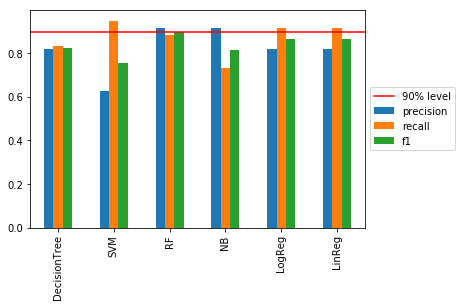

In [41]:
df[['precision', 'recall', 'f1']].plot(kind='bar');
plt.plot(list(range(-1,7)),[0.9]*8, color = "r",label = "90% level");
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1, fancybox=1);

As shown in above figure, the best matcher is random forest matcher with precision 91.38%, recall 88.33% and F1 89.93%. 